# **Birds of a feather**

---
## Dataset collection

I used [Daniel Bolton's `youtube-dl` tool](https://github.com/ytdl-org/youtube-dl) to download a [YouTube playlist of bird songs](https://www.youtube.com/playlist?list=OLAK5uy_klzCEn-DkrdZyf6XTp8Bes9WA8dFGSaME).


Command used:

```
$ youtube-dl -x --audio-format wav --no-cache-dir -o '~/generative-audio-parker-audio/downloaded/%(playlist_index)s - %(title)s.%(ext)s' https://www.youtube.com/playlist?list=OLAK5uy_klzCEn-DkrdZyf6XTp8Bes9WA8dFGSaME
```

In [1]:
from IPython.display import Audio

In [2]:
# Audio("downloaded/10 - Nachtigall (Luscinia megarhynchos).wav")

---
## Audio &rarr; Spectrogram

In [3]:
import librosa

In [4]:
samples, sample_rate = librosa.load("downloaded/10 - Nachtigall (Luscinia megarhynchos).wav")

In [5]:
sample_rate

22050

In [6]:
samples.shape

(4065870,)

In [7]:
S = librosa.feature.melspectrogram(y=samples, sr=sample_rate)

In [8]:
import matplotlib.pyplot as plt
import librosa.display
import numpy as np

In [9]:
def show_spectro(S, sr=22050, to_file=False, figsize=(10,4), dpi=None):
    
    plt.figure(figsize=figsize)
    S_dB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_dB, x_axis='time',
                             y_axis='mel', sr=sr,
                             fmax=8000)
    
    if to_file:
        plt.axis(False)
    else:
        plt.colorbar(format='%+2.0f dB')
        plt.title('Mel-frequency spectrogram')
        plt.tight_layout()
        plt.show()

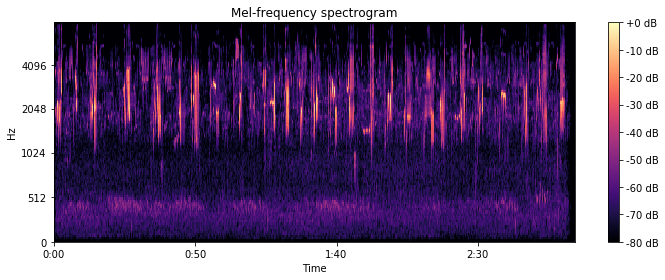

In [10]:
show_spectro(S)

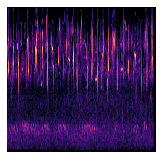

In [11]:
show_spectro(S, to_file="fp", figsize=(256/96, 256/96), dpi=96)

---
## Spectrogram &rarr; Audio

In [12]:
S.shape

(128, 7942)

In [14]:
%%time

#! NOTE: Takes a long time to inverse especially if the signal is complex.
#  (side note, for some reason each time I restart my datahub instance,
#   the amount of time this cell takes changes... was 22sec the
#   first time I tried, then 4min after a restart, and now 70sec...)
#
#  This should be fine since we're only going to be generating the output
#  at the end of the project, so we can leave it running!
inv = librosa.feature.inverse.mel_to_audio(S[:,:100])

CPU times: user 2min 46s, sys: 7min 55s, total: 10min 42s
Wall time: 1min 20s


In [15]:
inv

array([ 3.6512997e-06, -1.6410397e-05, -2.8541870e-05, ...,
        1.8090783e-02,  3.2328468e-02,  2.9426910e-02], dtype=float32)

In [16]:
# Audio(inv, rate=sample_rate)

---
## Convert dataset to training set

We're going to need to convert all of those wav files into rolling-window spectrograms.

In [17]:
len(inv) / sample_rate

2.2987755102040817

In [18]:
sample_rate / 512

43.06640625

In [19]:
# Note that every ~43 columns of my spectrogram S is a second of audio.


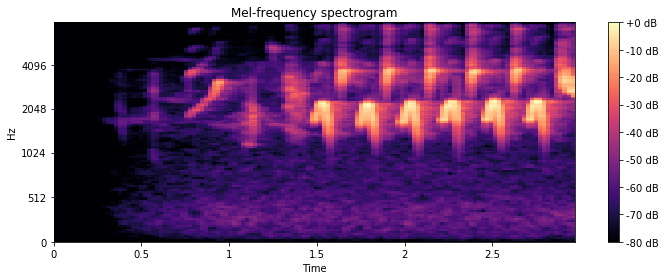

In [20]:
show_spectro(S[:,:128])

In [21]:
S[:,:128].shape

(128, 128)

In [22]:
print(S.max(), S.min())

544.30505 0.0


In [23]:
# This produces a cool looking visualization.
# I'll look into visualizations later if I have the time.

# plt.plot(S);

In [24]:
S_dB = librosa.power_to_db(S, ref=np.max)
S_dB[:,:128]

array([[-80.      , -80.      , -80.      , ..., -80.      , -80.      ,
        -80.      ],
       [-80.      , -80.      , -80.      , ..., -80.      , -79.40505 ,
        -80.      ],
       [-80.      , -80.      , -80.      , ..., -76.08479 , -77.28459 ,
        -76.81924 ],
       ...,
       [-80.      , -80.      , -80.      , ..., -53.38407 , -57.441128,
        -58.110607],
       [-80.      , -80.      , -80.      , ..., -57.713238, -61.782417,
        -62.604042],
       [-80.      , -80.      , -80.      , ..., -65.61616 , -69.496544,
        -73.792076]], dtype=float32)

In [25]:
print(S_dB.max(), S_dB.min())

1.9073486e-06 -80.0


In [26]:
def wav_to_db_spectro(fp, **kwargs):
    """
    Converts a wav file into a decibel spectrogram.
    
    :param fp: Filepath for the wav file.
    :type fp: str
    :param **kwargs: Optional keyword arguments for `librosa.feature.melspectrogram(...)`
    :returns: Decibel spectrogram
    :rtype: np.ndarray
    """
    
    samples, sample_rate = librosa.load(fp)
    
    S = librosa.feature.melspectrogram(y=samples, sr=sample_rate)
    
    S_dB = librosa.power_to_db(S, ref=np.max)
    
    return np.clip(S_dB, -80.0, 0.0)

In [27]:
def show_db_spectro(S_dB, **kwargs):
    
    plt.figure(**kwargs)
    
    librosa.display.specshow(S_dB, x_axis='time',
                             y_axis='mel',
                             fmax=8000)
    
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel-frequency spectrogram')
    plt.tight_layout()
    plt.show()

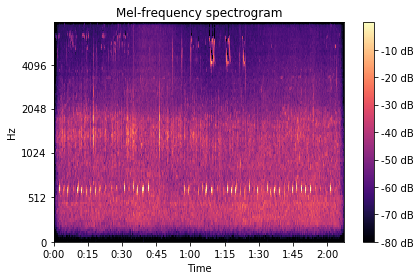

In [28]:
show_db_spectro(wav_to_db_spectro("downloaded/07 - Wiedehopf (Upupa epops).wav"))

In [29]:
# Audio("downloaded/07 - Wiedehopf (Upupa epops).wav")

In [42]:
sdb = wav_to_db_spectro("downloaded/01 - Amsel (Turdus merula).wav")

In [52]:
# Audio("downloaded/01 - Amsel (Turdus merula).wav")

In [43]:
def create_splits(S, stride=128):
    """
    Splits a decibel spectrogram into 128x128 slices with optional window overlap.
    Drops the last window if it doesn't contain 128 bands.
    
    .. todo:: Implement stride to allow overlapping windows.
    """
    
    #! TODO: Support overlapping windows
    splits = np.split(sdb, range(128, sdb.shape[1], 128), axis=1)
    
    if splits[-1].shape[1] < 128:
        splits = splits[:-1]
        
    return splits

In [44]:
splits = create_splits(sdb)

In [45]:
len(splits)

47

In [46]:
splits[-1].shape

(128, 128)

In [47]:
splits[0].shape

(128, 128)

In [48]:
s = librosa.db_to_power(splits[1])
inv = librosa.feature.inverse.mel_to_audio(s)

In [53]:
# Audio(inv, rate=sample_rate)

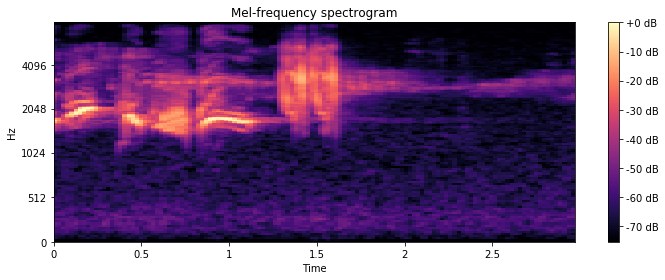

In [51]:
show_spectro(s)

In [82]:
import os

In [83]:
def save_spectrogram_splits(fp, outdir="spectrograms/splits/"):
    
    name = fp.split(' - ')[1].split(' ')[0]

    song = wav_to_db_spectro(fp)

    splits = create_splits(song)

    for idx, split in enumerate(splits):

        outfp = os.path.join(outdir, f"{name}{idx:03d}.npy")

        np.save(outfp, split)

In [84]:
import glob

In [85]:
for fp in glob.glob("downloaded/*"):
    
    save_spectrogram_splits(fp)

---
## Older work / staging area

Threatened birds in NA: https://www.birds-of-north-america.net/Threatened_Birds.html

Extinct birds in NA: https://www.birds-of-north-america.net/extinct-birds-of-north-america.html

Perhaps it would be interesting to make a point about birds going extinct.

https://www.xeno-canto.org/ allows searching for specific birds, so getting my data should be fine!

---

While I think of an artistic point, I should get started with the autoencoding.

[Tim Sainburg](https://github.com/timsainb/AVGN) recommends GAIA and Variational Autoencoder for generative use.

VAE: https://blog.keras.io/building-autoencoders-in-keras.html

Sainburg's models (includes VAE, GAIA, +): https://github.com/timsainb/tensorflow2-generative-models

TensorFlow Convolutional VAE tutorial: https://www.tensorflow.org/tutorials/generative/cvae

Music Autoencoders: https://blog.goodaudience.com/using-tensorflow-autoencoders-with-music-f871a76122ba

---
## I should use spectrograms instead perhaps...

https://www.tensorflow.org/tutorials/generative/cvae


https://github.com/tensorflow/docs/blob/master/site/en/r1/tutorials/sequences/audio_recognition.md

Use https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/wav_to_spectrogram to convert WAV to spectogram PNGs.

https://medium.com/red-buffer/autoencoders-guide-and-code-in-tensorflow-2-0-a4101571ce56

https://www.acoustics.asn.au/conference_proceedings/AAS2018/papers/p134.pdf